Import dados csv

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pickle

# Carregar os dados
df = pd.read_csv("../data_preparation/df_to_train_pos_neg.csv")
df['Total_Review'] = df['Total_Review'].fillna('')
df.head(5)

,Total_Review,review_type
0,beautiful hotel situated excellent location,positive
1,Lovely suite excellent spa facility comfortabl...,positive
2,Location close Metro bar prices,positive
3,clow important things visit city,positive
4,Great location trafalger staff great making ev...,positive


Criar vetorizador

In [2]:
# Vetorização com CountVectorizer para Gradient Boosting
count_vect = CountVectorizer(max_features=5000, ngram_range=(1, 2))
count_vect.fit(df.Total_Review)
text_vect_count = count_vect.transform(df.Total_Review)

In [3]:
# Vetorização com TF-IDF para LightGBM e CatBoost
tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
tfidf_vect.fit(df.Total_Review)
text_vect_tfidf = tfidf_vect.transform(df.Total_Review)

In [4]:
# Vetorização com HashingVectorizer para Random Forest
hash_vect = HashingVectorizer(n_features=2**20, alternate_sign=False)
text_vect_hash = hash_vect.transform(df.Total_Review)

Mapear valores para numéricos

In [5]:
y = df['review_type']
y = y.map({'positive': 1, 'negative': 0})

Dividir entre treino e teste

In [6]:
X_train_count, X_test_count, y_train, y_test = train_test_split(text_vect_count, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(text_vect_tfidf, y, test_size=0.2, random_state=42)
X_train_hash, X_test_hash, _, _ = train_test_split(text_vect_hash, y, test_size=0.2, random_state=42)

Função para verificar desempenho de modelo

In [7]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"### {model_name} ###")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    print(classification_report(y_test, y_pred))
    
    with open(f'{model_name.lower()}_model.pkl', 'wb') as f:
        pickle.dump(model, f)

Gradient Boosting

### Gradient Boosting ###
Accuracy: 0.8983954673141932


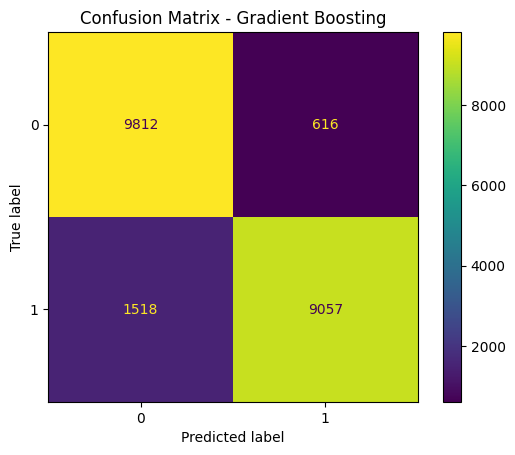

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     10428
           1       0.94      0.86      0.89     10575

    accuracy                           0.90     21003
   macro avg       0.90      0.90      0.90     21003
weighted avg       0.90      0.90      0.90     21003



In [8]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
train_and_evaluate_model(gbc, X_train_count, X_test_count, y_train, y_test, "Gradient Boosting")

LightGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 41932, number of negative: 42079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.312188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364025
[LightGBM] [Info] Number of data points in the train set: 84011, number of used features: 9842
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499125 -> initscore=-0.003500
[LightGBM] [Info] Start training from score -0.003500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

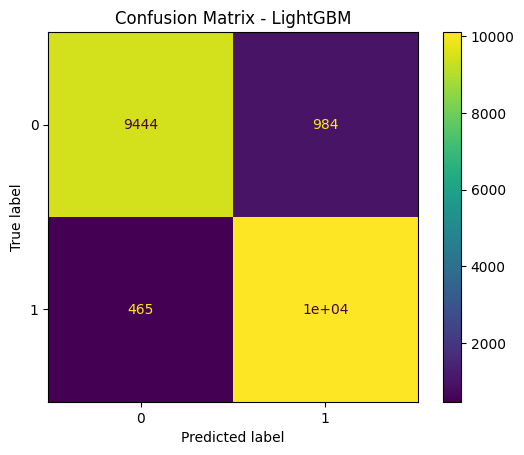

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     10428
           1       0.91      0.96      0.93     10575

    accuracy                           0.93     21003
   macro avg       0.93      0.93      0.93     21003
weighted avg       0.93      0.93      0.93     21003



In [9]:
lgbm = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=31, max_depth=7, random_state=42)
train_and_evaluate_model(lgbm, X_train_tfidf, X_test_tfidf, y_train, y_test, "LightGBM")

CatBoost

0:	learn: 0.6637939	total: 957ms	remaining: 15m 56s
100:	learn: 0.2862514	total: 55.5s	remaining: 8m 13s
200:	learn: 0.2410308	total: 1m 47s	remaining: 7m 8s
300:	learn: 0.2174601	total: 2m 40s	remaining: 6m 12s
400:	learn: 0.2025738	total: 3m 31s	remaining: 5m 15s
500:	learn: 0.1921493	total: 4m 22s	remaining: 4m 21s
600:	learn: 0.1846261	total: 5m 12s	remaining: 3m 27s
700:	learn: 0.1781348	total: 6m 5s	remaining: 2m 36s
800:	learn: 0.1732852	total: 6m 56s	remaining: 1m 43s
900:	learn: 0.1692468	total: 7m 46s	remaining: 51.2s
999:	learn: 0.1656987	total: 8m 36s	remaining: 0us
### CatBoost ###
Accuracy: 0.9301052230633718


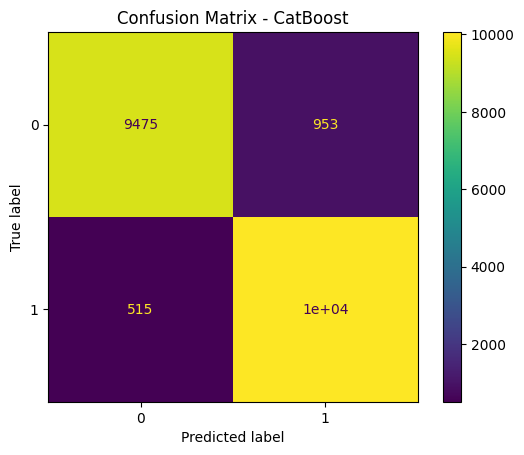

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     10428
           1       0.91      0.95      0.93     10575

    accuracy                           0.93     21003
   macro avg       0.93      0.93      0.93     21003
weighted avg       0.93      0.93      0.93     21003



In [10]:
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=100, random_seed=42)
train_and_evaluate_model(catboost, X_train_tfidf, X_test_tfidf, y_train, y_test, "CatBoost")

RandomForest

### Random Forest ###
Accuracy: 0.8386420987477979


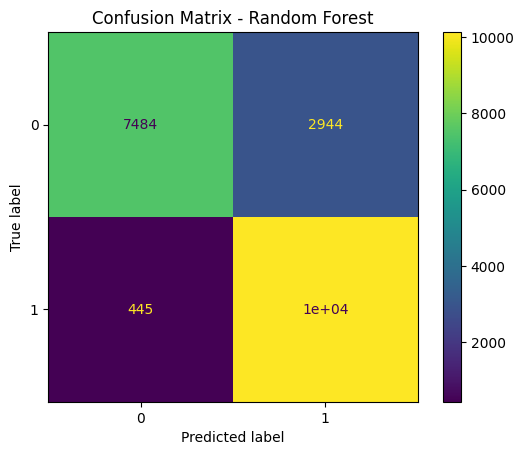

              precision    recall  f1-score   support

           0       0.94      0.72      0.82     10428
           1       0.77      0.96      0.86     10575

    accuracy                           0.84     21003
   macro avg       0.86      0.84      0.84     21003
weighted avg       0.86      0.84      0.84     21003



In [11]:
rf = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)
train_and_evaluate_model(rf, X_train_hash, X_test_hash, y_train, y_test, "Random Forest")

XGBoost

### XGBoost ###
Accuracy: 0.9057753654239871


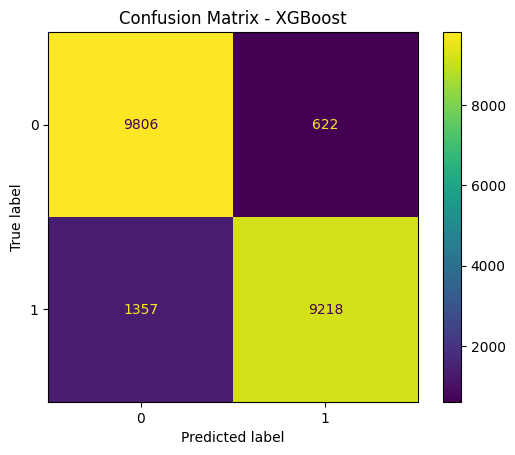

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     10428
           1       0.94      0.87      0.90     10575

    accuracy                           0.91     21003
   macro avg       0.91      0.91      0.91     21003
weighted avg       0.91      0.91      0.91     21003



In [12]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=600, objective='binary:logistic', learning_rate=0.05, max_depth=5, min_child_weight=3, random_state=42)
train_and_evaluate_model(xgb, X_train_hash, X_test_hash, y_train, y_test, "XGBoost")